In [1]:
import datetime as dt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from salishsea_tools import evaltools
from salishsea_tools import viz_tools


/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/evaltools.py:46: UserWarning: Neither Python Excel module ('openpyxl','xlrd') found
  warnings.warn("Neither Python Excel module ('openpyxl','xlrd') found",UserWarning)


In [6]:
thedir = '/'

In [2]:
def read_my_csv(filename):
    data = pd.read_csv(f'{thedir}{filename}', dtype={'Year': int, 'Month': int, 'Day': int}).drop(labels='Unnamed: 0', axis=1)
    data['datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour']])
    data = data.set_index('datetime')
    return data


In [128]:
def read_psf_csv(filename):
    data = pd.read_csv(filename, parse_dates=['dtUTC'])
    data = data.set_index('dtUTC')
    data = data.rename(columns={"NO23": "N"})
    return data

In [4]:
data = read_my_csv('ObsModel_202007D-again_TS_20150101-20150331.csv')
data2 = read_my_csv('ObsModel_202007D-again_TS_20150401-20150630.csv')
data3 = read_my_csv('ObsModel_202007D-again_TS_20150701-20150930.csv')
data4 = read_my_csv('ObsModel_202007D-again_TS_20151001-20151231.csv')
data = data.append([data2, data3, data4])

In [5]:
data

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,dtUTC,j,i,mod_vosaline,mod_votemper,k
datetime,,,,,,,,,,,,,,,
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,0.991487,25.146111,6.992043,2015-01-09 16:59:40,526,206,22.592567,6.247683,0
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,2.082117,25.243427,7.082535,2015-01-09 16:59:40,526,206,24.054422,6.876405,2
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,2.974446,25.319752,7.117362,2015-01-09 16:59:40,526,206,24.054422,6.876405,2
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,3.965919,25.378789,7.148240,2015-01-09 16:59:40,526,206,25.632427,7.421401,3
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,4.957386,25.423254,7.173524,2015-01-09 16:59:40,526,206,27.010500,7.857630,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,378.399211,31.442447,9.825992,2015-11-20 16:23:57,515,227,31.520758,9.791774,37
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,379.388870,31.443774,9.827257,2015-11-20 16:23:57,515,227,31.520758,9.791774,37
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,380.378524,31.445000,9.829926,2015-11-20 16:23:57,515,227,31.520758,9.791774,37


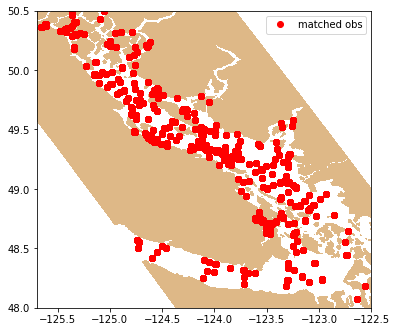

In [80]:
# plot matched data locations
fig, ax = plt.subplots(figsize = (6, 6))
viz_tools.set_aspect(ax, coords='map')
ax.plot(data['Lon'], data['Lat'], 'ro', label='matched obs')
bathy = '/home/sallen/MEOPAR/grid/bathymetry_201702.nc'
viz_tools.plot_land_mask(ax, bathy, coords='map', color='burlywood')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [17]:
def Plot_scatter(data, suptitle, filename, NSoG=False, old=True):
    fig = plt.figure(figsize = (7.5, 6.5))
    gs1 = gridspec.GridSpec(2, 4, left=.08, right=0.91, bottom=0.1, top=0.97,
                      wspace=0.2, width_ratios=[1, 0.1, 1, 0.1])
    axT = fig.add_subplot(gs1[1, 0])
    axS = fig.add_subplot(gs1[1, 2])
    gscb = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs1[1, 3])
    axcb = fig.add_subplot(gscb[1:-1])

    axS.plot((0,36), (0,36), 'k-', alpha=0.2)
    axT.plot((0,25), (0,25), 'k-', alpha=0.2)
    
    if not old:
        data['CT'] = data['ConsT']
        data['SA'] = data ['AbsSal']

    if NSoG:
        iiT = (~np.isnan(data['CT'])) & (~np.isnan(data['mod_votemper']) & (data['j'] >= 550))
        iiS = (~np.isnan(data['SA'])) & (~np.isnan(data['mod_vosaline']) & (data['j'] >= 550))
    else:
        iiT = (~np.isnan(data['CT'])) & (~np.isnan(data['mod_votemper']))
        iiS = (~np.isnan(data['SA'])) & (~np.isnan(data['mod_vosaline']))
    counts, xedges, yedges, m1 = axT.hist2d(data.loc[iiT,['CT']].values.flatten(),
                                      data.loc[iiT,['mod_votemper']].values.flatten(), bins=25*3, norm=LogNorm())
    counts, xedges, yedges, m2 = axS.hist2d(data.loc[iiS,['SA']].values.flatten(),
                                      data.loc[iiS,['mod_vosaline']].values.flatten(), bins=36*3, norm=LogNorm())

    cb = fig.colorbar(m1, cax=axcb)
    cb.set_label('Count')

    Smax = 35
    ntick = np.arange(0, Smax, 10)
    ntickl = [str(i) for i in ntick]
    axS.set_xlim((0, Smax))
    axS.set_ylim((0, Smax))
    axS.set_xticks(ntick)
    axS.set_xticklabels(ntickl)
    axS.set_yticks(ntick)
    axS.set_yticklabels(ntickl)

    Tmax = 25
    Tmin = 4
    stick=np.arange(Tmin, Tmax, 10)
    stickl=[str(i) for i in stick]
    axT.set_xlim((Tmin, Tmax))
    axT.set_ylim((Tmin, Tmax))
    axT.set_xticks(stick)
    axT.set_xticklabels(stickl)
    axT.set_yticks(stick)
    axT.set_yticklabels(stickl)
    
    for ax in (axT,axS):
        ax.set_aspect(1, adjustable='box')
        ax.set_ylabel('Modeled', fontsize=12)
        ax.set_xlabel('Observed', fontsize=12)

    axS.set_title('S$_A$ (g/kg)', fontsize=12)
    axT.set_title('$\Theta$ ($^{\circ}$C)', fontsize=12);
    
    axM = fig.add_subplot(gs1[0, 2])
    viz_tools.set_aspect(axM, coords='map')
    if NSoG:
        axM.plot(data['Lon'][data.j >= 550], data['Lat'][data.j >= 550], 'r.', 
                 label='matched obs')
    else:
        axM.plot(data['Lon'], data['Lat'], 'r.', 
                 label='matched obs')
    bathy = '/home/sallen/MEOPAR/grid/bathymetry_201702.nc'
    viz_tools.plot_land_mask(axM, bathy, coords='map', color='burlywood')
    axM.set_ylim(47.1, 51)
    axM.legend()
    axM.set_xlim(-126.2, -122.1);
    
    axW = fig.add_subplot(gs1[0, 0])
    axW.set(xlim=(0, 1), ylim=(0, 1))
    axW.text(0, 1, suptitle, fontsize=14)
    if NSoG:
        N, modmean, obsmean, bias, RMSE, WSS = evaltools.stats(data['CT'][data.j >= 550], 
                                                               data['mod_votemper'][data.j >= 550])
        NS, modmeanS, obsmeanS, biasS, RMSES, WSSS = evaltools.stats(data['SA'][data.j >= 550], 
                                                               data['mod_vosaline'][data.j >= 550])
    else:
        N, modmean, obsmean, bias, RMSE, WSS = evaltools.stats(data['CT'], data['mod_votemper'])
        NS, modmeanS, obsmeanS, biasS, RMSES, WSSS = evaltools.stats(data['SA'], data['mod_vosaline'])
    axW.text(0, 0.6, f'For Conservative Temperature ($^o$C)\n Bias: {bias: .2}\n RMSE: {RMSE: .2}\n WSS: {WSS: .3}\n for N: {N}')
    axW.text(0, 0.2, f'For Reference Salinity (g kg$^{{-1}}$)\n Bias: {biasS: .2}\n RMSE: {RMSES: .2}\n WSS: {WSSS: .3}\n for N: {NS}')
    axW.set_axis_off()
    
    plt.savefig(filename, facecolor='white')

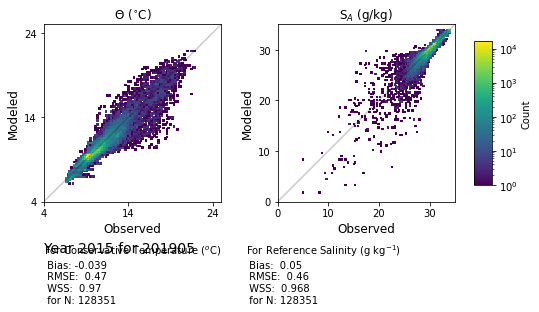

In [142]:
Plot_scatter(data, 'Year 2015 for 201905', 'y2015_201905.png')

In [90]:
print('CT:')
evaltools.printstats(data.loc[:], 'CT', 'mod_votemper')
print('SA:')
evaltools.printstats(data.loc[:], 'SA', 'mod_vosaline')

CT:
  N: 128351
  bias: -0.038949907143921436
  RMSE: 0.47235251011346624
  WSS: 0.9696857398175632
SA:
  N: 128351
  bias: 0.04988975961998321
  RMSE: 0.4636887884385062
  WSS: 0.9678477511500964


In [3]:
data = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C/ObsModel_202007C_TS_20150101-20150331.csv')
data2 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C/ObsModel_202007C_TS_20150401-20150630.csv')
data3 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C/ObsModel_202007C_TS_20150701-20150930.csv')
data4 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C/ObsModel_202007C_TS_20151001-20151231.csv')
data = data.append([data2, data3, data4])

In [4]:
data

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,dtUTC,j,i,mod_vosaline,mod_votemper,k
datetime,,,,,,,,,,,,,,,
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,0.991487,25.146111,6.992043,2015-01-09 16:59:40,526,206,22.764341,6.226627,0
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,2.082117,25.243427,7.082535,2015-01-09 16:59:40,526,206,24.175283,6.845332,2
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,2.974446,25.319752,7.117362,2015-01-09 16:59:40,526,206,24.175283,6.845332,2
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,3.965919,25.378789,7.148240,2015-01-09 16:59:40,526,206,25.470818,7.329982,3
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,4.957386,25.423254,7.173524,2015-01-09 16:59:40,526,206,26.740862,7.559564,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,378.399211,31.442447,9.825992,2015-11-20 16:23:57,515,227,31.545265,9.812012,37
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,379.388870,31.443774,9.827257,2015-11-20 16:23:57,515,227,31.545265,9.812012,37
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,380.378524,31.445000,9.829926,2015-11-20 16:23:57,515,227,31.545265,9.812012,37


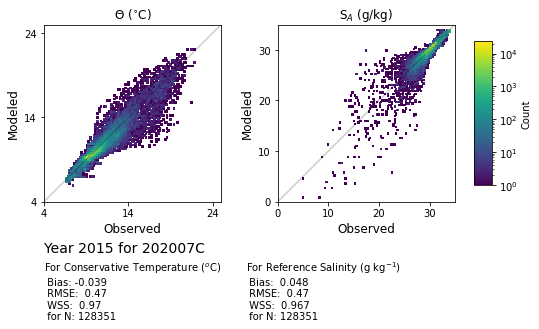

In [7]:
Plot_scatter(data, 'Year 2015 for 202007C', 'y2015_202007C.png')

In [5]:
data = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p1/ObsModel_202007Cp1_TS_20150101-20150331.csv')
data2 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p1/ObsModel_202007Cp1_TS_20150401-20150630.csv')
data3 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p1/ObsModel_202007Cp1_TS_20150701-20150930.csv')
data4 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p1/ObsModel_202007Cp1_TS_20151001-20151231.csv')
data = data.append([data2, data3, data4])

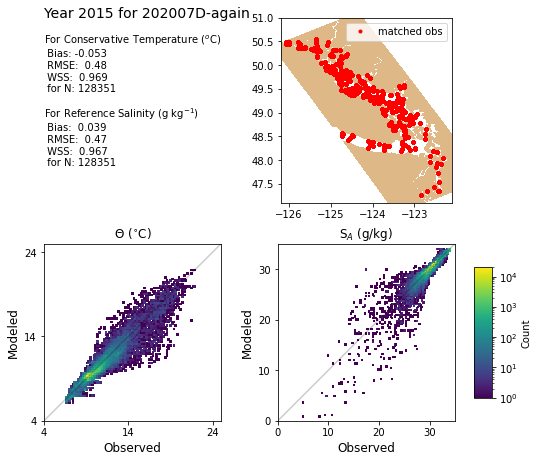

In [8]:
Plot_scatter(data, 'Year 2015 for 202007D-again', 'y2015_202007D-again.png')

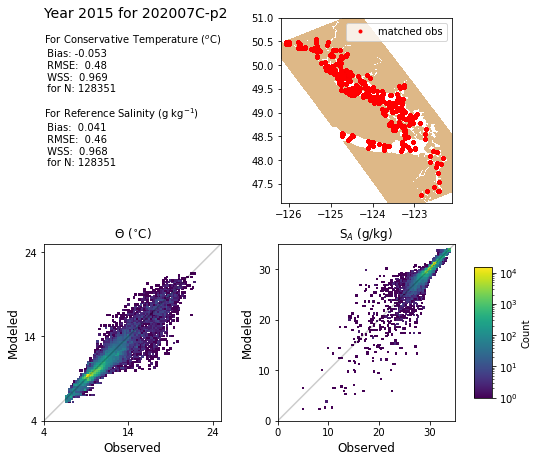

In [51]:
data = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p2/ObsModel_202007Cp2_TS_20150101-20150331.csv')
data2 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p2/ObsModel_202007Cp2_TS_20150401-20150630.csv')
data3 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p2/ObsModel_202007Cp2_TS_20150701-20150930.csv')
data4 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p2/ObsModel_202007Cp2_TS_20151001-20151231.csv')
data = data.append([data2, data3, data4])
Plot_scatter(data, 'Year 2015 for 202007C-p2', 'y2015_202007Cp2.png')

## 201905, year 2015, NSoG aka ii >= 550

In [10]:
! ls Obs*

ObsModel_201812_Bio_20150101-20151231.csv
ObsModel_201812_Bio_20150101-20151231.yaml
ObsModel_201812_Bio_20150101-20151231.yaml~
ObsModel_201812_Bio_20160101-20160630.csv
ObsModel_201812_Bio_20160101-20160630.yaml~
ObsModel_201812_Bio_20170101-20170630.csv
ObsModel_201812_Bio_20170101-20170630.yaml~
ObsModel_201812_TS_20150101-20150331.yaml
ObsModel_201812_TS_20150101-20150331.yaml~
ObsModel_201812_TS_20150401-20150630.yaml~
ObsModel_201812_TS_20150701-20150930.yaml~
ObsModel_201812_TS_20151001-20151231.yaml~
ObsModel_201905_Bio_20150101-20151231.csv
ObsModel_201905_Bio_20150101-20151231.yaml~
ObsModel_201905_Bio_20160101-20160630.csv
ObsModel_201905_Bio_20160101-20160630.yaml~
ObsModel_201905_Bio_20170101-20170630.csv
ObsModel_201905_Bio_20170101-20170630.yaml~
ObsModel_201905_TS_20150101-20150331.csv
ObsModel_201905_TS_20150101-20150331.yaml
ObsModel_201905_TS_20150101-20150331.yaml~
ObsModel_201905_TS_20150401-20150630.csv
ObsModel_201905_TS_20150401-20150630.yaml
ObsModel_201905_TS

In [15]:
data = read_my_csv('ObsModel_201905_TS_20150101-20150331.csv')
data2 = read_my_csv('ObsModel_201905_TS_20150401-20150630.csv')
data3 = read_my_csv('ObsModel_201905_TS_20150701-20150930.csv')
data4 = read_my_csv('ObsModel_201905_TS_20151001-20151231.csv')
data = data.append([data2, data3, data4])
data

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,dtUTC,j,i,mod_vosaline,mod_votemper,k
datetime,,,,,,,,,,,,,,,
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,0.991487,25.146111,6.992043,2015-01-09 16:59:40,526,206,22.744120,6.221077,0
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,2.082117,25.243427,7.082535,2015-01-09 16:59:40,526,206,24.124413,6.821640,2
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,2.974446,25.319752,7.117362,2015-01-09 16:59:40,526,206,24.124413,6.821640,2
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,3.965919,25.378789,7.148240,2015-01-09 16:59:40,526,206,25.366739,7.318912,3
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,4.957386,25.423254,7.173524,2015-01-09 16:59:40,526,206,26.680536,7.574944,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,378.399211,31.442447,9.825992,2015-11-20 16:23:57,515,227,31.531868,9.801119,37
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,379.388870,31.443774,9.827257,2015-11-20 16:23:57,515,227,31.531868,9.801119,37
2015-11-20 16:23:57.000001200,2015,11,20,16.399167,49.321833,-123.937000,380.378524,31.445000,9.829926,2015-11-20 16:23:57,515,227,31.531868,9.801119,37


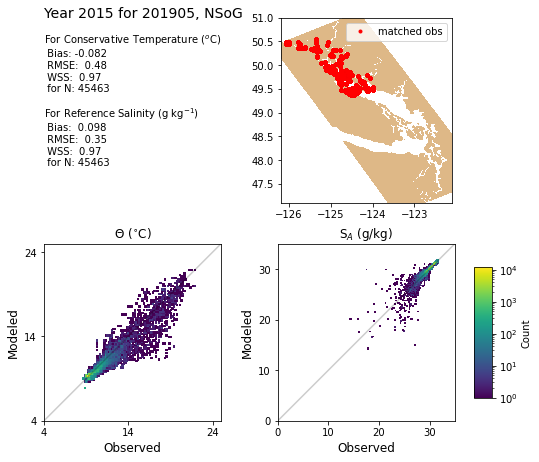

In [43]:
Plot_scatter(data, 'Year 2015 for 201905, NSoG', 'y2015_NSoG_201905.png', NSoG=True)

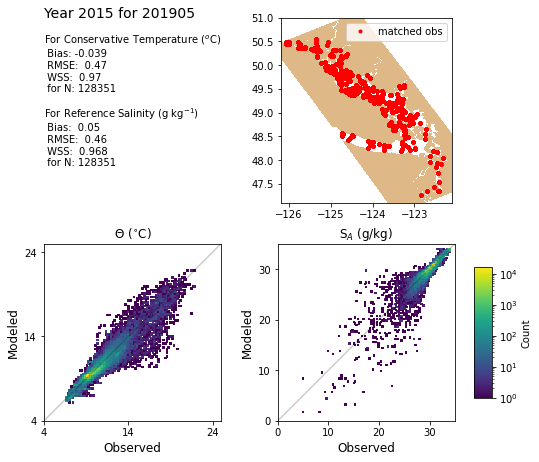

In [44]:
Plot_scatter(data, 'Year 2015 for 201905', 'y2015_201905.png')

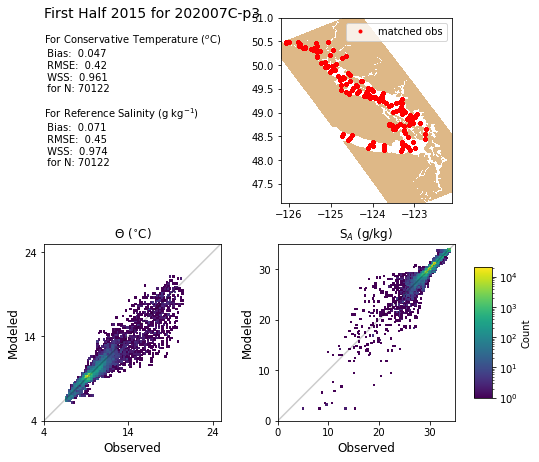

In [19]:
data = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p3/ObsModel_202007Cp3_TS_20150101-20150331.csv')
data2 = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p3/ObsModel_202007Cp3_TS_20150401-20150630.csv')
data = data.append([data2])
Plot_scatter(data, 'First Half 2015 for 202007C-p3', 'y2015fh_202007Cp3.png', old=True)

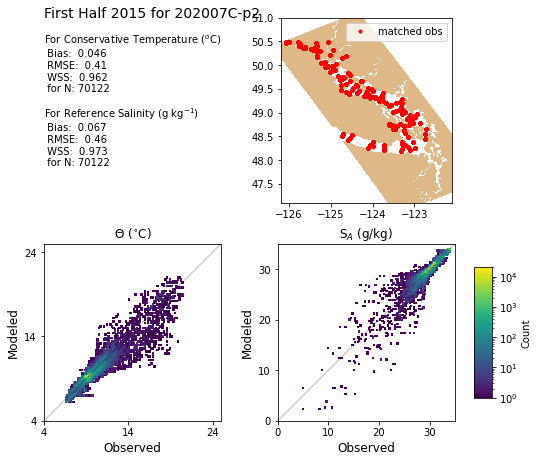

In [18]:
datao = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p2/ObsModel_202007Cp2_TS_20150101-20150331.csv')
data2o = read_my_csv('/data/sallen/results/MEOPAR/202007/202007C-p2/ObsModel_202007Cp2_TS_20150401-20150630.csv')
datao = datao.append([data2o])
Plot_scatter(datao, 'First Half 2015 for 202007C-p2', 'y2015fh_202007Cp2.png', old=True)

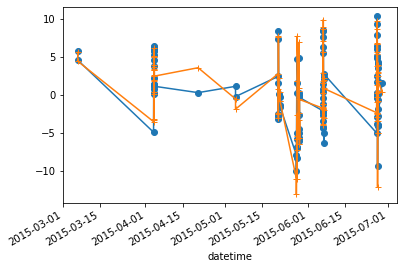

In [25]:
(datao.mod_vosaline - datao.SA)[datao.SA < 20].plot(marker = 'o')
(data.mod_vosaline - data.SA)[data.SA < 20].plot(marker = '+');

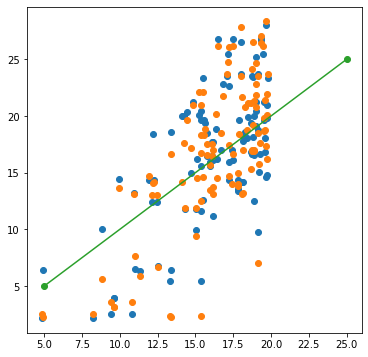

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.plot(datao.SA[datao.SA < 20], datao.mod_vosaline[datao.SA < 20], 'o')
plt.plot(data.SA[data.SA < 20], data.mod_vosaline[data.SA < 20], 'o')
plt.plot([5, 25], [5, 25], 'o-')

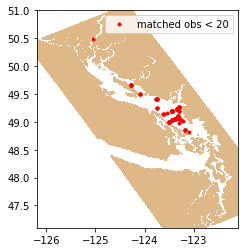

In [34]:
fig, axM = plt.subplots(1, 1)
viz_tools.set_aspect(axM, coords='map')
axM.plot(data['Lon'][data.SA < 20], data['Lat'][data.SA < 20], 'r.', 
                 label='matched obs < 20')

bathy = '/home/sallen/MEOPAR/grid/bathymetry_201702.nc'
viz_tools.plot_land_mask(axM, bathy, coords='map', color='burlywood')
axM.set_ylim(47.1, 51)
axM.legend()
axM.set_xlim(-126.2, -122.1);

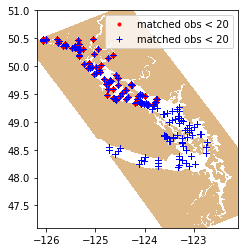

In [119]:
sL = 35; jL = 0; zL = 0
fig, axM = plt.subplots(1, 1)
viz_tools.set_aspect(axM, coords='map')
axM.plot(data['Lon'][(data.SA < sL) & (data.j > 500) & (data.Z > zL)], data['Lat'][(data.SA < sL) & (data.j > 500) & (data.Z > zL)], 'r.', 
                 label='matched obs < 20')
axM.plot(data['Lon'][(data.SA < sL) & (data.j > jL) & (data.Z > zL)], data['Lat'][(data.SA < sL) & (data.j > jL) & (data.Z > zL)], 'b+', 
                 label='matched obs < 20')

bathy = '/home/sallen/MEOPAR/grid/bathymetry_201702.nc'
viz_tools.plot_land_mask(axM, bathy, coords='map', color='burlywood')
axM.set_ylim(47.1, 51)
axM.legend()
axM.set_xlim(-126.2, -122.1);

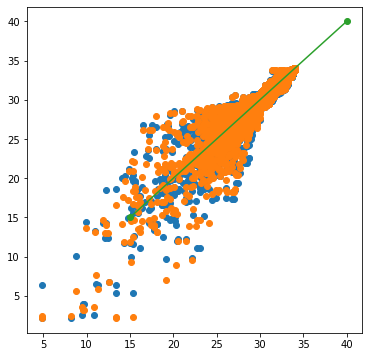

In [120]:
zL = 0
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.plot(datao.SA[(data.SA < sL) & (data.j > jL) & (data.Z > zL)], datao.mod_vosaline[(data.SA < sL) & (data.j > jL) & (data.Z > zL)], 'o')
plt.plot(data.SA[(data.SA < sL) & (data.j > jL) & (data.Z > zL)], data.mod_vosaline[(data.SA < sL) & (data.j > jL) & (data.Z > zL)], 'o')
plt.plot([15, sL+5], [15, sL+5], 'o-');

In [121]:
-(datao.SA[(data.SA < sL) & (data.j > jL) & (data.Z > zL)] - datao.mod_vosaline[(data.SA < sL) & (data.j > jL) & (data.Z > zL)] ).mean()

0.06741491960496278

In [122]:
-(data.SA[(data.SA < sL) & (data.j > jL) & (data.Z > zL)] - data.mod_vosaline[(data.SA < sL) & (data.j > jL)& (data.Z > zL)] ).mean()

0.07139229712078336

In [123]:
(datao.SA[(data.SA < sL) & (data.j > jL) & (data.Z > zL)] - datao.mod_vosaline[(data.SA < sL) & (data.j > jL) & (data.Z > zL)]).std()

0.45472095023884423

In [124]:
(data.SA[(data.SA < sL) & (data.j > jL) & (data.Z > zL)] - data.mod_vosaline[(data.SA < sL) & (data.j > jL) & (data.Z > zL)]).std()

0.4422252037685866

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,dtUTC,j,i,mod_vosaline,mod_votemper,k
datetime,,,,,,,,,,,,,,,
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,0.991487,25.146111,6.992043,2015-01-09 16:59:40,526,206,23.080105,6.278394,0
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,2.082117,25.243427,7.082535,2015-01-09 16:59:40,526,206,23.978008,6.788848,2
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,2.974446,25.319752,7.117362,2015-01-09 16:59:40,526,206,23.978008,6.788848,2
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,3.965919,25.378789,7.148240,2015-01-09 16:59:40,526,206,25.445484,7.320621,3
2015-01-09 16:59:39.999998400,2015,1,9,16.994444,49.328833,-124.080833,4.957386,25.423254,7.173524,2015-01-09 16:59:40,526,206,26.454168,7.639304,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-29 23:33:15.999998400,2015,6,29,23.554444,50.386467,-125.616150,37.570373,30.429303,10.630834,2015-06-29 23:33:16,842,112,30.617859,10.373986,22
2015-06-29 23:33:15.999998400,2015,6,29,23.554444,50.386467,-125.616150,38.660703,30.433107,10.626315,2015-06-29 23:33:16,842,112,30.617859,10.373986,22
2015-06-29 23:33:15.999998400,2015,6,29,23.554444,50.386467,-125.616150,39.751027,30.435707,10.622823,2015-06-29 23:33:16,842,112,30.656788,10.328861,23


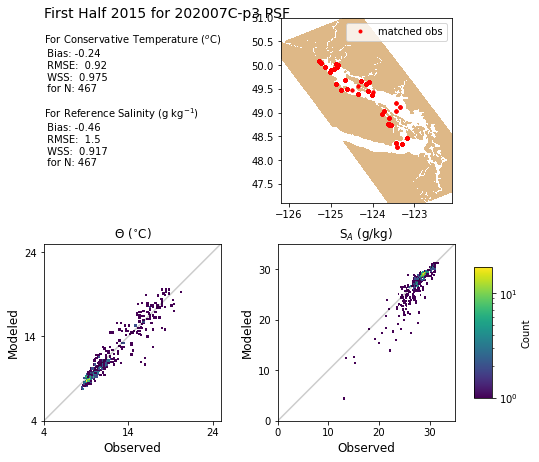

In [129]:
data = read_psf_csv('/data/sallen/results/MEOPAR/202007/202007C-p3/ObsModel_202007Cp3_PSF_20150101-20150630.csv')
Plot_scatter(data, 'First Half 2015 for 202007C-p3 PSF', 'y2015fhPSF_202007Cp3.png', old=True)

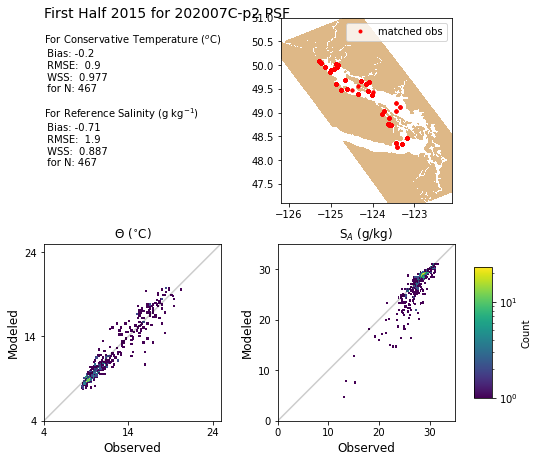

In [130]:
datao = read_psf_csv('/data/sallen/results/MEOPAR/202007/202007C-p2/ObsModel_202007Cp2_PSF_20150101-20150630.csv')
Plot_scatter(datao, 'First Half 2015 for 202007C-p2 PSF', 'y2015fhPSF_202007Cp2.png', old=True)